## Model Evaluation
Section 6.1 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/soccercpd'

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from src.myconstants import *

sns.set(font='Arial', font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the human-annoatated data

Formation and role labels annotated by domain experts for comparison with the predicted labels

In [4]:
role_tags_true = pd.read_csv('data/role_tags_true.csv', header=0)
role_tags_true

,activity_id,role_period,session,start_time,end_time,formation,squad_num,aligned_role
0,2310,1,1,0,36,4231,1,GK
1,2310,1,1,0,36,4231,4,RCB
2,2310,1,1,0,36,4231,7,LM
3,2310,1,1,0,36,4231,14,CAM
4,2310,1,1,0,36,4231,18,CF
...,...,...,...,...,...,...,...,...
1713,21704,7,2,11,50,442,51,GK
1714,21704,7,2,11,50,442,62,RCM
1715,21704,7,2,11,50,442,9,RCF
1716,21704,7,2,11,50,442,17,RB


In [5]:
form_tags_true = role_tags_true[role_tags_true.columns[:-2]].drop_duplicates().reset_index(drop=True)
form_tags_true

,activity_id,role_period,session,start_time,end_time,formation
0,2310,1,1,0,36,4231
1,2310,2,1,36,46,4231
2,2310,3,2,0,22,4231
3,2310,4,2,22,42,4231
4,2310,5,2,42,51,433
...,...,...,...,...,...,...
151,21704,3,1,24,31,4231
152,21704,4,1,31,47,4231
153,21704,5,2,0,5,442
154,21704,6,2,5,11,442


### Formatting the predicted formation data

Format the formation and role labels predicted by SoccerCPD

In [6]:
role_periods = pd.read_csv('data/role_periods.csv', header=0)
form_periods = pd.read_pickle('data/form_periods.pkl')

cols = [LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_FORMATION]
form_tags_pred = pd.merge(role_periods, form_periods[cols])

activity_ids = form_tags_true[LABEL_ACTIVITY_ID].unique()
form_tags_pred = form_tags_pred[
    form_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)
].reset_index(drop=True)
form_tags_pred

,activity_id,player_period,form_period,role_period,session,start_time,end_time,formation
0,2310,1,1,1,1,0,35,442
1,2310,1,1,2,1,35,46,442
2,2310,2,2,3,2,0,22,343
3,2310,3,2,4,2,22,42,343
4,2310,4,2,5,2,42,51,343
...,...,...,...,...,...,...,...,...
147,21704,1,1,3,1,23,31,4231
148,21704,1,1,4,1,31,47,4231
149,21704,2,2,5,2,0,6,442
150,21704,2,2,6,2,6,11,442


### Compute the confusion matrix for formation prediction

In [7]:
form_header = [LABEL_ACTIVITY_ID, LABEL_SESSION, LABEL_START_TIME, LABEL_FORMATION]
role_header = form_header[:3] + [LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]

In [8]:
def generate_minute_segments_inner(records, i, mode='form'):
    row = records.iloc[i]

    start_time = row[LABEL_START_TIME]
    end_time = row[LABEL_END_TIME]
    duration = end_time - start_time
    
    cols = form_header if mode == 'form' else role_header
    minute_df = pd.DataFrame(np.repeat(row[cols].values[np.newaxis], duration, axis=0), columns=cols)
    minute_df[LABEL_START_TIME] = np.arange(start_time, end_time)
    
    return minute_df

In [9]:
def generate_minute_segments(records, mode='form'):
    minute_df_list = Parallel(n_jobs=50)(
        delayed(generate_minute_segments_inner)(records, i, mode=mode)
        for i in tqdm(records.index)
    )
    cols = form_header if mode == 'form' else role_header
    return pd.concat(minute_df_list).sort_values(cols)

In [10]:
minute_df_true = generate_minute_segments(form_tags_true)
minute_df_true

100%|██████████| 156/156 [00:01<00:00, 119.32it/s]


,activity_id,session,start_time,formation
0,2310,1,0,4231
1,2310,1,1,4231
2,2310,1,2,4231
3,2310,1,3,4231
4,2310,1,4,4231
...,...,...,...,...
34,21704,2,45,442
35,21704,2,46,442
36,21704,2,47,442
37,21704,2,48,442


In [11]:
minute_df_pred = generate_minute_segments(form_tags_pred)
minute_df_pred

  0%|          | 0/152 [00:00<?, ?it/s]

100%|██████████| 152/152 [00:00<00:00, 3787.90it/s]


,activity_id,session,start_time,formation
0,2310,1,0,442
1,2310,1,1,442
2,2310,1,2,442
3,2310,1,3,442
4,2310,1,4,442
...,...,...,...,...
34,21704,2,45,442
35,21704,2,46,442
36,21704,2,47,442
37,21704,2,48,442


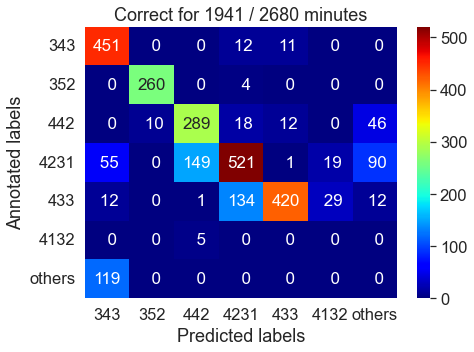

In [12]:
formations = ['343', '352', '442', '4231', '433', '4132', 'others']
minute_df_true[LABEL_FORMATION] = minute_df_true[LABEL_FORMATION].astype(str).apply(
    lambda x: x if x in formations[:-1] else 'others'
)

conf_mat = confusion_matrix(
    minute_df_true[LABEL_FORMATION].values,
    minute_df_pred[LABEL_FORMATION].values,
    labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(7, 5))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='jet', annot=True, fmt='3d', annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig('img/form_conf.pdf', bbox_inches='tight')

In [13]:
minute_df = pd.merge(minute_df_true, minute_df_pred, on=form_header[:3])
discords = minute_df[minute_df['formation_x'] != minute_df['formation_y']]
discords.groupby([LABEL_ACTIVITY_ID, LABEL_SESSION, 'formation_x', 'formation_y']).first().reset_index()

,activity_id,session,formation_x,formation_y,start_time
0,2310,1,4231,442,0
1,2310,2,4231,343,0
2,2310,2,433,343,42
3,5090,1,4231,others,39
4,5090,2,4231,others,0
5,5090,2,433,others,8
6,5420,1,4231,4132,0
7,5420,1,433,4132,19
8,5420,2,442,433,36
9,5458,1,others,343,0


### Compute the confusion matrix for role prediction

In [14]:
right_cols = HEADER_ROLE_RECORDS[:5] + [LABEL_FORMATION, LABEL_PLAYER_ID, LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]
role_records = pd.read_csv('data/role_records.csv', header=0)
role_tags_pred = pd.merge(role_periods, role_records[right_cols])

In [15]:
activity_ids = role_tags_true[LABEL_ACTIVITY_ID].unique()
records = role_tags_pred[role_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)].reset_index(drop=True)
minute_df_pred = generate_minute_segments(records, mode='role')
minute_df_pred

  0%|          | 0/1505 [00:00<?, ?it/s]

100%|██████████| 1505/1505 [00:04<00:00, 350.77it/s]


,activity_id,session,start_time,squad_num,aligned_role
0,2310,1,0,4,RCB
0,2310,1,0,7,LM
0,2310,1,0,14,LCF
0,2310,1,0,18,RCF
0,2310,1,0,19,LCM
...,...,...,...,...,...
38,21704,2,49,20,RCB
38,21704,2,49,21,RM
38,21704,2,49,23,LCF
38,21704,2,49,28,LCB


In [16]:
minute_df_true = generate_minute_segments(role_tags_true, mode='role')
minute_df_true = pd.merge(minute_df_pred[role_header[:-1]], minute_df_true)
minute_df_true

  0%|          | 0/1718 [00:00<?, ?it/s]

100%|██████████| 1718/1718 [00:04<00:00, 362.37it/s]


,activity_id,session,start_time,squad_num,aligned_role
0,2310,1,0,4,RCB
1,2310,1,0,7,LM
2,2310,1,0,14,CAM
3,2310,1,0,18,CF
4,2310,1,0,19,LDM
...,...,...,...,...,...
26647,21704,2,49,20,LCB
26648,21704,2,49,21,RM
26649,21704,2,49,23,LCF
26650,21704,2,49,28,RCB


In [17]:
np.sort(minute_df_pred[LABEL_ALIGNED_ROLE].unique())

array(['CAM', 'CB', 'CDM', 'CF', 'LB', 'LCB', 'LCF', 'LCM', 'LDM', 'LM',
       'LWB', 'RB', 'RCB', 'RCF', 'RCM', 'RDM', 'RM', 'RWB'], dtype=object)

Text(106.5, 0.5, 'Annotated labels')

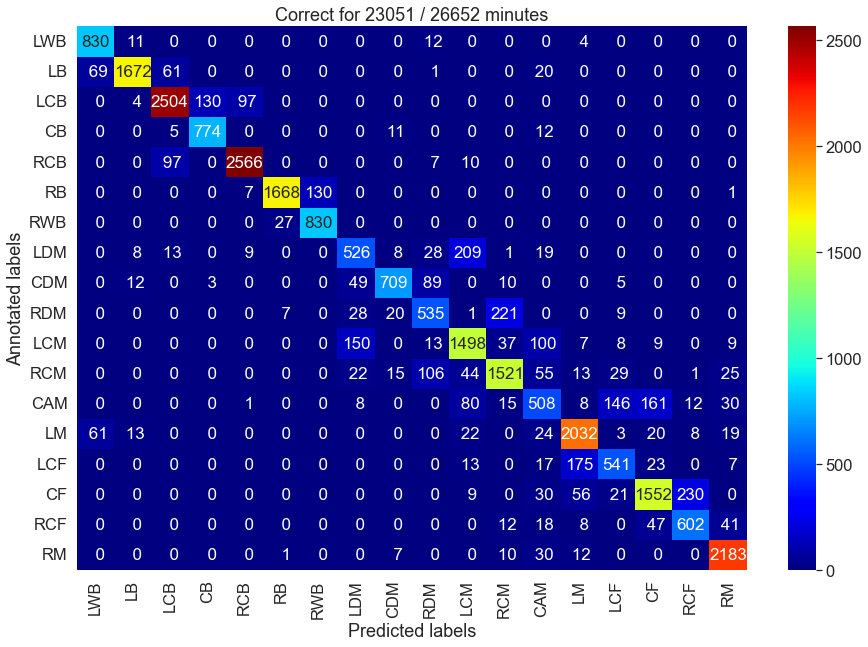

In [18]:
roles = [
    'LWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'RWB',
    'LDM', 'CDM', 'RDM', 'LCM', 'RCM', 'CAM',
    'LM', 'LCF', 'CF', 'RCF', 'RM'
]
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles
)
conf_mat = pd.DataFrame(conf_mat, index=roles, columns=roles)
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='jet', annot=True, fmt='3d', annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")

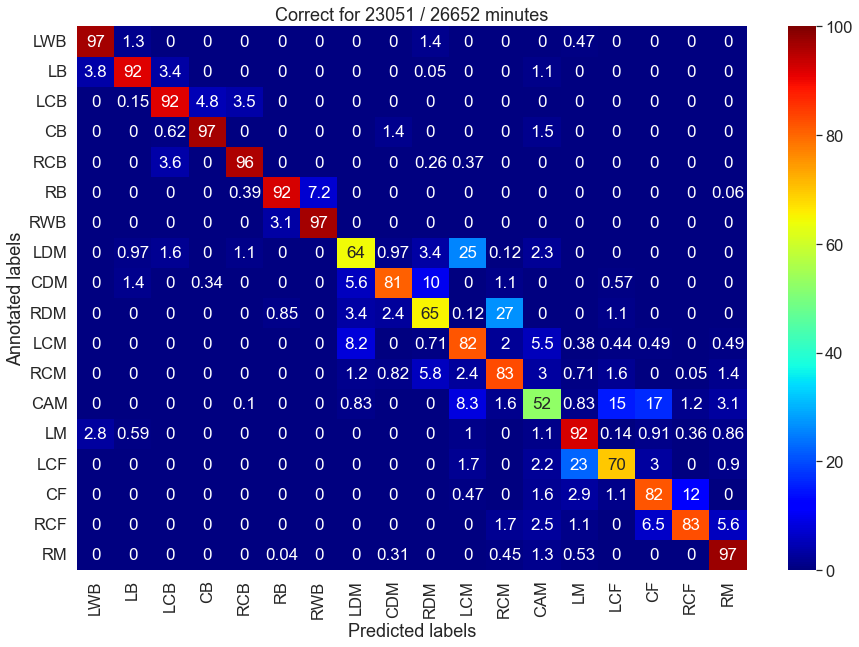

In [19]:
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles, normalize='true'
)
conf_mat = pd.DataFrame(conf_mat, index=roles, columns=roles).round(4) * 100
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, vmin=0, vmax=100, cmap='jet', annot=True, annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig('img/role_conf.pdf', bbox_inches='tight')